<a href="https://colab.research.google.com/github/Aayush-Borkar/ML-Lab/blob/main/bonus_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [10]:
df = pd.read_csv("Telco-Customer-Churn.csv")

In [11]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [12]:
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                     'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                     'PaperlessBilling', 'PaymentMethod', 'Churn']

df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

df[numeric_cols] = StandardScaler().fit_transform(df[numeric_cols])

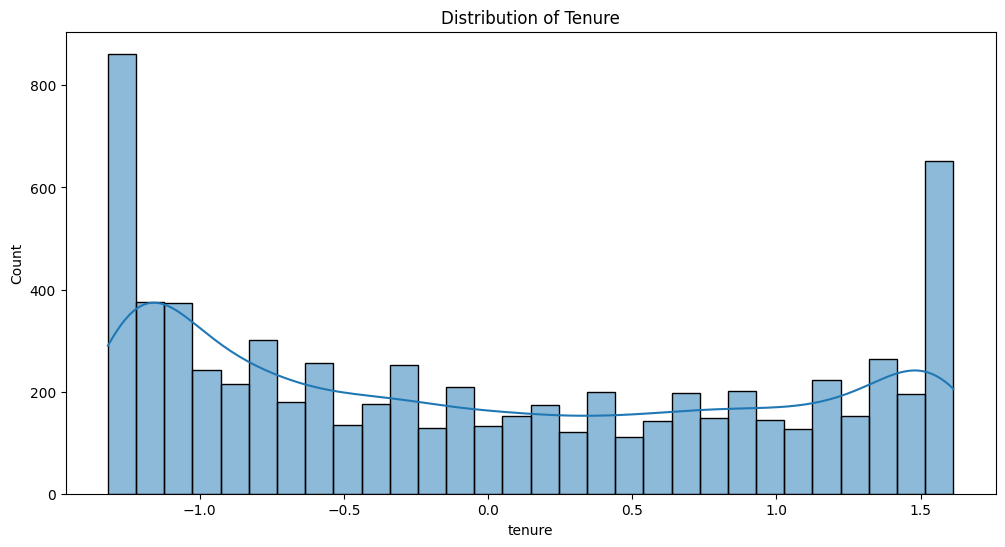

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df['tenure'], bins=30, kde=True)
plt.title('Distribution of Tenure')
plt.show()

<ipython-input-14-770756e2d793>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='coolwarm')


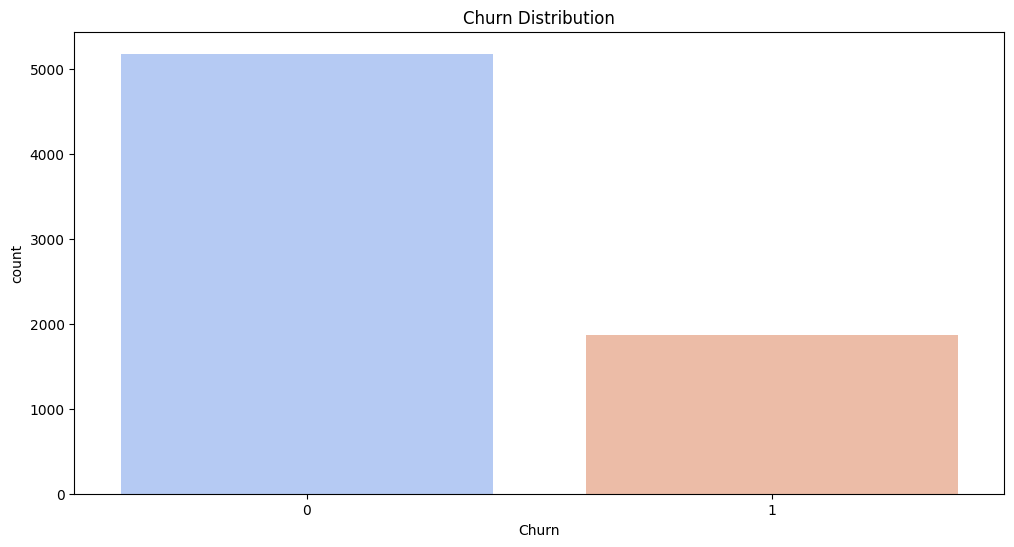

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Churn', data=df, palette='coolwarm')
plt.title('Churn Distribution')
plt.show()

In [15]:
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Decision Tree with Hyperparameter Tuning
param_grid_dt = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
dt_tuned = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
dt_tuned.fit(X_train, y_train)
y_pred = dt_tuned.best_estimator_.predict(X_test)
print("Decision Tree Performance (With Hyperparameter Tuning):")
print(classification_report(y_test, y_pred))

Decision Tree Performance (With Hyperparameter Tuning):
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1036
           1       0.61      0.64      0.62       373

    accuracy                           0.80      1409
   macro avg       0.74      0.75      0.74      1409
weighted avg       0.80      0.80      0.80      1409



In [17]:
# Random Forest with Hyperparameter Tuning
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10]}
rf_tuned = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.best_estimator_.predict(X_test)
print("Random Forest Performance (With Hyperparameter Tuning):")
print(classification_report(y_test, y_pred))

Random Forest Performance (With Hyperparameter Tuning):
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.67      0.51      0.58       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



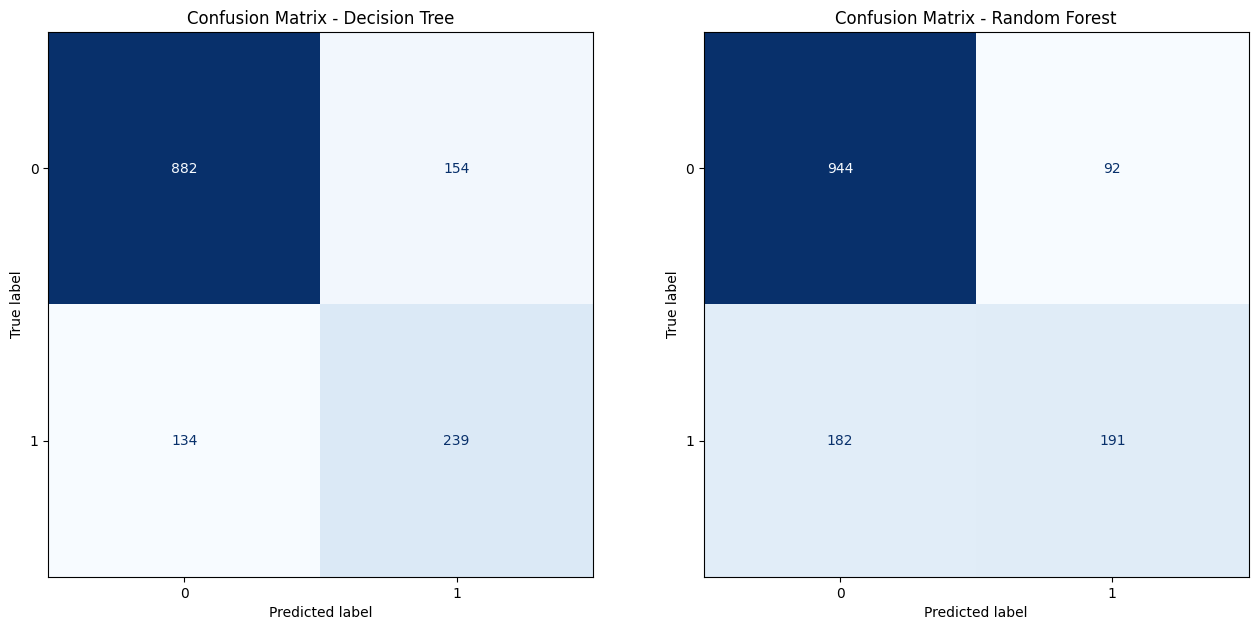

In [18]:
models = {
    'Decision Tree': dt_tuned.best_estimator_,
    'Random Forest': rf_tuned.best_estimator_,
}
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Confusion Matrix - {name}')
if len(models) < len(axes):
    for j in range(len(models), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

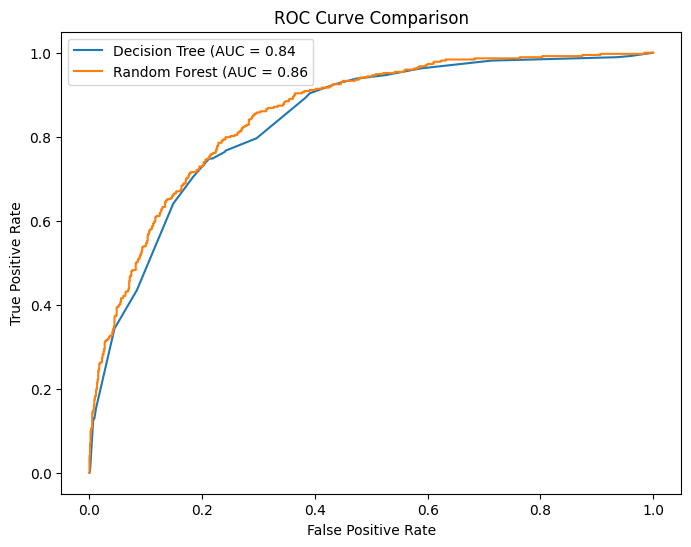

In [19]:
# ROC Curve Comparison
plt.figure(figsize=(8,6))
models = {'Decision Tree': dt_tuned.best_estimator_, 'Random Forest': rf_tuned.best_estimator_}
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

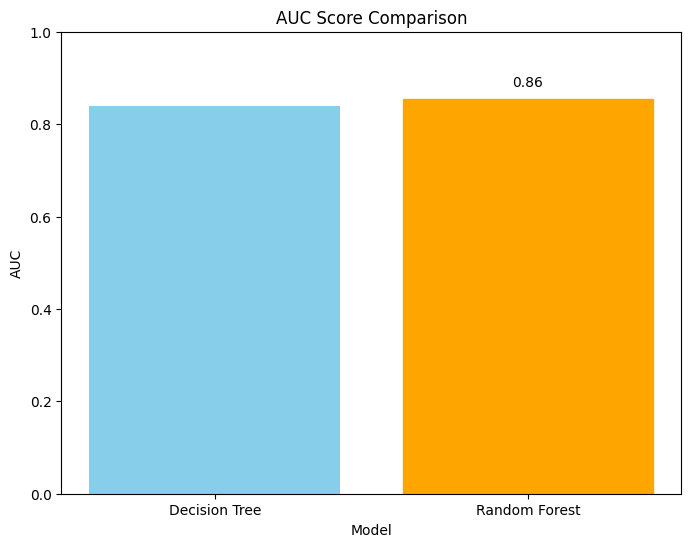

In [20]:
auc_scores = []
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    auc_scores.append(auc_score)

max_auc_score = max(auc_scores)
max_auc_index = auc_scores.index(max_auc_score)
max_auc_model = list(models.keys())[max_auc_index]

plt.figure(figsize=(8, 6))
bars = plt.bar(models.keys(), auc_scores, color='skyblue')

bars[max_auc_index].set_color('orange')

plt.title('AUC Score Comparison')
plt.xlabel('Model')
plt.ylabel('AUC')
plt.ylim(0, 1)
plt.text(max_auc_index, max_auc_score + 0.02, f'{max_auc_score:.2f}', ha='center', va='bottom', color='black')
plt.show()